<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
Coding Neural Network - Forward Propagation and Backpropagation
</h1><br>

**Why Neural Networks?**

According to *Universal Approximate Theorem*, Neural Networks can approximate as well as learn and represent any function given a large enough layer and desired error margin. The way neural network learns the true function is by building complex representations on top of simple ones. On each hidden layer, the neural network learns new feature space by first compute the affine (linear) transformations of the given inputs and then apply non-linear function which in turn will be the input of the next layer. This process will continue until we reach the output layer. Therefore, we can define neural network as information flows from inputs through hidden layers towards the output. For a 3-layers neural network, the learned function would be: $f(x) = f_3(f_2(f_1(x)))$ where:
- $f_1(x)$: Function learned on first hidden layer
- $f_2(x)$: Function learned on second hidden layer
- $f_3(x)$: Function learned on output layer

Therefore, on each layer we learn different representation that gets more complicated with later hidden layers.Below is an example of a 3-layers neural network (we don't count input layer):
<p align="center">
<img src="images/neural_net.jpg"><br>
<caption><center><u><b><font color="purple">Figure 1:</font></b></u> Neural Network with two hidden layers</center></caption>
</p>

For example, computers can't understand images directly and don't know what to do with pixels data. However, a neural network can build a simple representation of the image in the early hidden layers that identifies edges. Given the first hidden layer output, it can learn corners and contours. Given the second hidden layer, it can learn parts such as nose. Finally, it can learn the object identity.

Since **truth is never linear** and representation is very critical to the performance of a machine learning algorithm, neural network can help us build very complex models and leave it to the algorithm to learn such representations without worrying about feature engineering that takes practitioners very long time and effort to curate a good representation. 

The notebook has two parts:
1. [Coding the neural network](#Coding the NN): This entails writing all the helper functions that would allow us to implement a multi-layer neural network. While doing so, I'll explain the theoretical parts whenever possible and give some advices on implementations.
2. [Application](#Application): We'll implement the neural network we coded in the first part on image recognition problem to see if the network we built will be able to detect if the image has a cat or a dog and see it working :)

In [1]:
# Import packages
import os as os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
sns.set_context("notebook")
plt.style.use("fivethirtyeight")

<a id="Coding the NN"></a>

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
I. Coding The Neural Network
</h2>

<h3 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Forward Propagation
</h3>

The input $X$ provides the initial information that then propagates to the hidden units at each layer and finally produce the output $\widehat{Y}$. The architecture of the network entails determining its depth, width, and activation functions used on each layer. **Depth** is the number of hidden layers. **Width** is the number of units (nodes) on each hidden layer since we don't control neither input layer nor output layer dimensions. There are quite a few set of activation functions such *Rectified Linear Unit, Sigmoid, Hyperbolic tangent, etc*. Research has proven that deeper networks outperform networks with more hidden units. Therefore, it's always better and won't hurt to train a deeper network (with diminishing returns).

Lets first introduce some notations that will be used throughout the notebook:
* $W^l$: Weights matrix for the $l^{th}$ layer
* $b^l$: Bias vector for the $l^{th}$ layer
* $Z^l$: Linear (affine) transformations of given inputs for the $l^{th}$ layer
* $g^l$: Activation function applied on the $l^{th}$ layer
* $A^l$: Post-activation output for the $l^{th}$ layer
* $dW^l$: Derivative of the cost function w.r.t  $W^l$ ($\frac{\partial J}{\partial W^l}$)
* $db^l$: Derivative of the cost function w.r.t $b^l$ ($\frac{\partial J}{\partial b^l})$)
* $dZ^l$: Derivative of the cost function w.r.t $Z^l$ ($\frac{\partial J}{\partial Z^l}$)
* $dA^l$: Derivative of the cost function w.r.t $A^l$ ($\frac{\partial J}{\partial A^l}$)
* $n^l$: Number of units (nodes) of the $l^{th}$ layer
* $m$: Number of examples
* $L$: Number of layers in the network (not including the input layer)

Next, we'll write down the dimensions of a multi-layer neural network in the general form to help us in matrix multiplication because one of the major challenges in implementing a neural network is getting the dimensions right.
* $W^l,\ dW^l$: Number of units (nodes) in $l^{th}$ layer x Number of units (nodes) in $l - 1$ layer
* $b^l,\ db^l$: Number of units (nodes) in $l^{th}$ layer x 1
* $Z^l,\ dZ^l$: Number of units (nodes) in $l^{th}$ layer x number of examples
* $A^l,\ dA^l$: Number of units (nodes) in $l^{th}$ layer x number of examples

The two equations we need to implement forward propagations are:
$$Z^l = W^lA^{l - 1} + b ^l\tag1\\{}$$
$$A^l = g^l(Z^l) = g^l(W^lA^{l - 1} + b ^l)\tag2$$
These computations will take place on each layer.

<h3 style="font-family: Georgia; font-size:1.3em;color:purple; font-style:bold">
Parameters Initialization
</h3><br>
We'll first initialize the weight matrices and the bias vectors. It's important to note that we shouldn't initialize all the parameters to zero because doing so will lead the gradients to be equal and on each iteration the output would be the same and the learning algorithm won't learn anything. Therefore, it's important to randomly initialize the parameters to values between 0 and 1. It's also recommended to multiply the random values by small scalar such as 0.01 to make the activation units active and be on the regions where activation functions' derivatives are not close to zero.

In [9]:
# Initialize parameters
def initialize_parameters(layers_dims):
    """
    Initialize parameters dictionary.
    
    Weight matrices will be initialized to random values from uniform normal
    distribution.
    bias vectors will be initialized to zeros.

    Arguments
    ---------
    layers_dims : list or array-like
        dimensions of each layer in the network.

    Returns
    -------
    parameters : dict
        weight matrix and the bias vector for each layer.
    """
    np.random.seed(1)               
    parameters = {}
    L = len(layers_dims)            

    for l in range(1, L):           
        parameters["W" + str(l)] = np.random.randn(
            layers_dims[l], layers_dims[l - 1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))

        assert parameters["W" + str(l)].shape == (
            layers_dims[l], layers_dims[l - 1])
        assert parameters["b" + str(l)].shape == (layers_dims[l], 1)

    return parameters

<h3 style="font-family: Georgia; font-size:1.3em;color:purple; font-style:bold">
Activation Functions
</h3><br>
There is no definitive guide for which activation function works best on specific problems. It's a trial and error process where one should try different set of functions and see which one works best on the problem at hand. We'll cover 4 of the most commonly used activation functions:
- **Sigmoid function ($\sigma$)**: $g(z) = \frac{1}{1 + e^{-z}}$. It's recommended to be used only on the output layer so that we can easily interpret the output as probabilities since it has restricted output between 0 and 1. One of the main disadvantages for using sigmoid function on hidden layers is that the gradient is very close to zero over a large portion of its domain which makes it slow and harder for the learning algorithm to learn.
- **Hyperbolic Tangent function**: $g(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$. It's superior to sigmoid function in which the mean of its output is very close to zero, which in other words center the output of the activation units around zero and make the range of values very small which means faster to learn. The disadvantage that it shares with sigmoid function is that the gradient is very small on good portion of the domain.
- **Rectified Linear Unit (ReLU)**: $g(z) = max\{0, z\}$. The models that are close to linear are easy to optimize. Since ReLU shares a lot of the properties of linear functions, it tends to work well on most of the problems. The only issue is that the derivative is not defined at $z = 0$, which we can overcome by assigning the derivative to 0 at $z = 0$. However, this means that for $z\leq 0$ the gradient is zero and again can't learn.
- **Leaky Rectified Linear Unit**: $g(z) = max\{\alpha*z, z\}$. It overcomes the zero gradient issue from ReLU and assigns $\alpha$ which is a small value for $z\leq 0$.

If you're not sure which activation function to choose, start with ReLU.

Next, we'll implement the above activation functions and draw a graph for each one to make it easier to see the domain and range of each function.

In [16]:
# Define activation functions that will be used in forward propagation
def sigmoid(Z):
    """
    Computes the sigmoid of Z element-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = 1 / (1 + np.exp(-Z))

    return A, Z


def tanh(Z):
    """
    Computes the Hyperbolic Tagent of Z elemnet-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = np.tanh(Z)

    return A, Z


def relu(Z):
    """
    Computes the Rectified Linear Unit (ReLU) element-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = np.maximum(0, Z)

    return A, Z


def leaky_relu(Z):
    """
    Computes Leaky Rectified Linear Unit element-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = np.maximum(0.1 * Z, Z)

    return A, Z

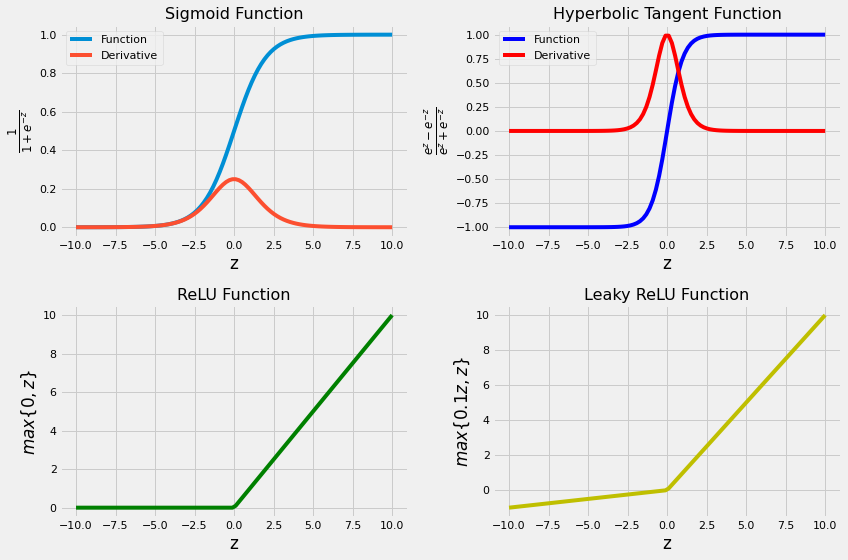

In [22]:
# Plot the 4 activation functions
z = np.linspace(-10, 10, 100)

# Computes post-activation outputs
A_sigmoid, z = sigmoid(z)
A_tanh, z = tanh(z)
A_relu, z = relu(z)
A_leaky_relu, z = leaky_relu(z)

# Plot sigmoid
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(z, A_sigmoid, label = "Function")
plt.plot(z, A_sigmoid * (1 - A_sigmoid), label = "Derivative")
plt.legend(loc = "upper left")
plt.xlabel("z")
plt.ylabel(r"$\frac{1}{1 + e^{-z}}$")
plt.title("Sigmoid Function", fontsize = 16)
# Plot tanh
plt.subplot(2, 2, 2)
plt.plot(z, A_tanh, 'b', label = "Function")
plt.plot(z, 1 - np.square(A_tanh), 'r',label = "Derivative")
plt.legend(loc = "upper left")
plt.xlabel("z")
plt.ylabel(r"$\frac{e^z - e^{-z}}{e^z + e^{-z}}$")
plt.title("Hyperbolic Tangent Function", fontsize = 16)
# plot relu
plt.subplot(2, 2, 3)
plt.plot(z, A_relu, 'g')
plt.xlabel("z")
plt.ylabel(r"$max\{0, z\}$")
plt.title("ReLU Function", fontsize = 16)
# plot leaky relu
plt.subplot(2, 2, 4)
plt.plot(z, A_leaky_relu, 'y')
plt.xlabel("z")
plt.ylabel(r"$max\{0.1z, z\}$")
plt.title("Leaky ReLU Function", fontsize = 16)
plt.tight_layout();

<h3 style="font-family: Georgia; font-size:1.3em;color:purple; font-style:bold">
Feed Forward
</h3><br>
Given its inputs from previous layer, each unit computes affine transformation $z = W^Tx + b$ and then apply an activation function $g(z)$ such as ReLU element-wise. During the process, we'll store (cache) all variables computed and used on each layer to be used in back-propagation. We'll write first two helper functions that will be used in the L-model forward propagation to make it easier to debug. Keep in mind that on each layer, we may have different activation function.

In [23]:
# Define helper functions that will be used in L-model forward prop
def linear_forward(A_prev, W, b):
    """
    Computes affine transformation of the input.

    Arguments
    ---------
    A_prev : 2d-array
        activations output from previous layer.
    W : 2d-array
        weight matrix, shape: size of current layer x size of previuos layer.
    b : 2d-array
        bias vector, shape: size of current layer x 1.

    Returns
    -------
    Z : 2d-array
        affine transformation output.
    cache : tuple
        stores A_prev, W, b to be used in backpropagation.
    """
    Z = np.dot(W, A_prev) + b
    cache = (A_prev, W, b)

    return Z, cache


def linear_activation_forward(A_prev, W, b, activation_fn):
    """
    Computes post-activation output using non-linear activation function.

    Arguments
    ---------
    A_prev : 2d-array
        activations output from previous layer.
    W : 2d-array
        weight matrix, shape: size of current layer x size of previuos layer.
    b : 2d-array
        bias vector, shape: size of current layer x 1.
    activation_fn : str
        non-linear activation function to be used: "sigmoid", "tanh", "relu".

    Returns
    -------
    A : 2d-array
        output of the activation function.
    cache : tuple
        stores linear_cache and activation_cache. ((A_prev, W, b), Z) to be used in backpropagation.
    """
    assert activation_fn == "sigmoid" or activation_fn == "tanh" or \
        activation_fn == "relu"

    if activation_fn == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation_fn == "tanh":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)

    elif activation_fn == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    assert A.shape == (W.shape[0], A_prev.shape[1])

    cache = (linear_cache, activation_cache)

    return A, cache


def L_model_forward(X, parameters, hidden_layers_activation_fn="relu"):
    """
    Computes the output layer through looping over all units in topological
    order.

    Arguments
    ---------
    X : 2d-array
        input matrix of shape input_size x training_examples.
    parameters : dict
        contains all the weight matrices and bias vectors for all layers.
    hidden_layers_activation_fn : str
        activation function to be used on hidden layers: "tanh", "relu".

    Returns
    -------
    AL : 2d-array
        probability vector of shape 1 x training_examples.
    caches : list
        that contains L tuples where each layer has: A_prev, W, b, Z.
    """
    A = X                           
    caches = []                     
    L = len(parameters) // 2        

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(
            A_prev, parameters["W" + str(l)], parameters["b" + str(l)],
            activation_fn=hidden_layers_activation_fn)
        caches.append(cache)

    AL, cache = linear_activation_forward(
        A, parameters["W" + str(L)], parameters["b" + str(L)],
        activation_fn="sigmoid")
    caches.append(cache)

    assert AL.shape == (1, X.shape[1])

    return AL, caches

<h3 style="font-family: Georgia; font-size:1.3em;color:purple; font-style:bold">
Cost
</h3><br>
We'll use the binary **Cross-Entropy** cost. It uses the log-likelihood method to estimate its error. The cost is:
$$J(W, b) = -\frac{1}{m}\sum_{i = 1}^m\big(y^ilog(\widehat{y^i}) + (1 - y^i)log(1 - \widehat{y^i})\big)\tag3$$
The above cost function is convex; however, neural network usually stuck on a local minimum and is not guaranteed to find the optimal parameters. We'll use here gradient-based learning.

In [19]:
# Compute cross-entropy cost
def compute_cost(AL, y):
    """
    Computes the binary Cross-Entropy cost.

    Arguments
    ---------
    AL : 2d-array
        probability vector of shape 1 x training_examples.
    y : 2d-array
        true "label" vector.

    Returns
    -------
    cost : float
        binary cross-entropy cost.
    """
    m = y.shape[1]              
    cost = - (1 / m) * np.sum(
        np.multiply(y, np.log(AL)) + np.multiply(1 - y, np.log(1 - AL)))

    return cost

<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Back-Propagation
</h2>

Backpropagation allows the information to go back from the cost backward through the network in order to compute the gradient. Therefore, loop over the nodes starting at the final node in reverse topological order to compute the derivative of the final node output with respect to each edge's node tail. Doing so will help us know who is responsible for the most error and change the parameters in that direction. The following derivatives' formulas will help us write the back-propagate functions:
$$dA^L = \frac{A^L - Y}{A^L(1 - A^L)}\tag4\\{}$$
$$dZ^L = A^L - Y\tag5\\{}$$
$$dW^l = \frac{1}{m}dZ^l{A^{l - 1}}^T\tag6\\{}$$
$$db^l = \frac{1}{m}\sum_i(dZ^l)\tag7\\{}$$
$$dA^{l - 1} = {W^l}^TdZ^l\tag8\\{}$$
$$dZ^{l} = dA^l*g^{'l}(Z^l)\tag9\\{}$$
Since $b^l$ is always a vector, the sum would be across rows (since each column is an example).

In [20]:
# Define derivative of activation functions w.r.t z that will be used in back-propagation
def sigmoid_gradient(dA, Z):
    """
    Computes the gradient of sigmoid output w.r.t input Z.

    Arguments
    ---------
    dA : 2d-array
        post-activation gradient, of any shape.
    Z : 2d-array
        input used for the activation fn on this layer.

    Returns
    -------
    dZ : 2d-array
        gradient of the cost with respect to Z.
    """
    A, Z = sigmoid(Z)
    dZ = dA * A * (1 - A)

    return dZ


def tanh_gradient(dA, Z):
    """
    Computes the gradient of hyperbolic tangent output w.r.t input Z.

    Arguments
    ---------
    dA : 2d-array
        post-activation gradient, of any shape.
    Z : 2d-array
        input used for the activation fn on this layer.

    Returns
    -------
    dZ : 2d-array
        gradient of the cost with respect to Z.
    """
    A, Z = tanh(Z)
    dZ = dA * (1 - np.square(A))

    return dZ


def relu_gradient(dA, Z):
    """
    Computes the gradient of ReLU output w.r.t input Z.

    Arguments
    ---------
    dA : 2d-array
        post-activation gradient, of any shape.
    Z : 2d-array
        input used for the activation fn on this layer.

    Returns
    -------
    dZ : 2d-array
        gradient of the cost with respect to Z.
    """
    A, Z = relu(Z)
    dZ = np.multiply(dA, np.int64(A > 0))

    return dZ


# define helper functions that will be used in L-model back-prop
def linear_backword(dZ, cache):
    """
    Computes the gradient of the output w.r.t weight, bias, and post-activation
    output of (l - 1) layers at layer l.

    Arguments
    ---------
    dZ : 2d-array
        gradient of the cost w.r.t. the linear output (of current layer l).
    cache : tuple
        values of (A_prev, W, b) coming from the forward propagation in the current layer.

    Returns
    -------
    dA_prev : 2d-array
        gradient of the cost w.r.t. the activation (of the previous layer l-1).
    dW : 2d-array
        gradient of the cost w.r.t. W (current layer l).
    db : 2d-array
        gradient of the cost w.r.t. b (current layer l).
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert dA_prev.shape == A_prev.shape
    assert dW.shape == W.shape
    assert db.shape == b.shape

    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation_fn):
    """
    Arguments
    ---------
    dA : 2d-array
        post-activation gradient for current layer l.
    cache : tuple
        values of (linear_cache, activation_cache).
    activation : str
        activation used in this layer: "sigmoid", "tanh", or "relu".

    Returns
    -------
    dA_prev : 2d-array
        gradient of the cost w.r.t. the activation (of the previous layer l-1), same shape as A_prev.
    dW : 2d-array
        gradient of the cost w.r.t. W (current layer l), same shape as W.
    db : 2d-array
        gradient of the cost w.r.t. b (current layer l), same shape as b.
    """
    linear_cache, activation_cache = cache

    if activation_fn == "sigmoid":
        dZ = sigmoid_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)

    elif activation_fn == "tanh":
        dZ = tanh_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)

    elif activation_fn == "relu":
        dZ = relu_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, y, caches, hidden_layers_activation_fn="relu"):
    """
    Computes the gradient of output layer w.r.t weights, biases, etc. starting
    on the output layer in reverse topological order.

    Arguments
    ---------
    AL : 2d-array
        probability vector, output of the forward propagation (L_model_forward()).
    y : 2d-array
        true "label" vector (containing 0 if non-cat, 1 if cat).
    caches : list
        list of caches for all layers.
    hidden_layers_activation_fn :
        activation function used on hidden layers: "tanh", "relu".

    Returns
    -------
    grads : dict
        with the gradients.
    """
    y = y.reshape(AL.shape)
    L = len(caches)
    grads = {}

    dAL = np.divide(AL - y, np.multiply(AL, 1 - AL))

    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads[
        "db" + str(L)] = linear_activation_backward(
            dAL, caches[L - 1], "sigmoid")

    for l in range(L - 1, 0, -1):
        current_cache = caches[l - 1]
        grads["dA" + str(l - 1)], grads["dW" + str(l)], grads[
            "db" + str(l)] = linear_activation_backward(
                grads["dA" + str(l)], current_cache,
                hidden_layers_activation_fn)

    return grads


# define the function to update both weight matrices and bias vectors
def update_parameters(parameters, grads, learning_rate):
    """
    Update the parameters' values using gradient descent rule.

    Arguments
    ---------
    parameters : dict
        contains all the weight matrices and bias vectors for all layers.
    grads : dict
        stores all gradients (output of L_model_backward).

    Returns
    -------
    parameters : dict
        updated parameters.
    """
    L = len(parameters) // 2

    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters[
            "W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters[
            "b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters

<a id="Application"></a>

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
II. Application
</h2>

The dataset that we'll be working on has 209 images. Each image is 64 x 64 pixels on RGB scale. We'll build a neural network to classify if the image has a cat or not. Therefore, $y^i \in \{0, 1\}.$
- We'll first load the images.
- Show sample image for a cat.
- Reshape input matrix so that each column would be one example. Also, since each image is 64 x 64 x 3, we'll end up having 12,288 features for each image. Therefore, the input matrix would be 12,288 x 209.
- Standardize the data so that the gradients don't go out of control. Also, it will help hidden units have similar range of values. For now, we'll divide every pixel by 255 which shouldn't be an issue. However, it's better to standardize the data to have a mean of 0 and a standard deviation of 1.

Original dimensions:
--------------------
Training: (209, 64, 64, 3), (209,)
Test: (50, 64, 64, 3), (50,)

New dimensions:
---------------
Training: (12288, 209), (1, 209)
Test: (12288, 50), (1, 50)


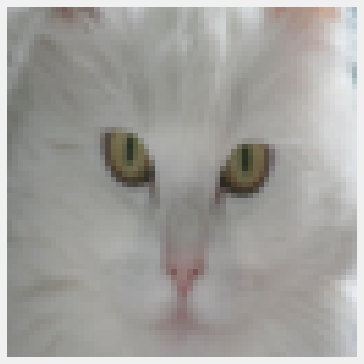

In [27]:
# Import training dataset
train_dataset = h5py.File("../data/train_catvnoncat.h5")
X_train = np.array(train_dataset["train_set_x"])ain_catvnoncat.h5")
y_train = np.array(train_dataset["train_set_y"])

test_dataset = h5py.File("../data/test_catvnoncat.h5")
X_test = np.array(test_dataset["test_set_x"])
y_test = np.array(test_dataset["test_set_y"])

# print the shape of input data and label vector
print(f"""Original dimensions:\n{20 * '-'}\nTraining: {X_train.shape}, {y_train.shape}
Test: {X_test.shape}, {y_test.shape}""")

# plot cat image
plt.figure(figsize=(6, 6))
plt.imshow(X_train[50])
plt.axis("off");

# Transform input data and label vector
X_train = X_train.reshape(209, -1).T
y_train = y_train.reshape(-1, 209)

X_test = X_test.reshape(50, -1).T
y_test = y_test.reshape(-1, 50)

# standarize the data
X_train = X_train / 255
X_test = X_test / 255

print(f"""\nNew dimensions:\n{15 * '-'}\nTraining: {X_train.shape}, {y_train.shape}
Test: {X_test.shape}, {y_test.shape}""")

Now, our dataset is ready to be used and test our neural network implementation. Let's first write **multi-layer model** function to implement gradient-based learning using predefined number of iterations and learning rate.

In [ ]:
# Define the multi-layer model using all the helper functions we wrote before


def L_layer_model(
        X, y, layers_dims, learning_rate=0.01, num_iterations=3000,
        print_cost=True, hidden_layers_activation_fn="relu"):
    """
    Implements multilayer neural network using gradient descent as the
    learning algorithm.

    Arguments
    ---------
    X : 2d-array
        data, shape: number of examples x num_px * num_px * 3.
    y : 2d-array
        true "label" vector, shape: 1 x number of examples.
    layers_dims : list
        input size and size of each layer, length: number of layers + 1.
    learning_rate : float
        learning rate of the gradient descent update rule.
    num_iterations : int
        number of iterations of the optimization loop.
    print_cost : bool
        if True, it prints the cost every 100 steps.
    hidden_layers_activation_fn : str
        activation function to be used on hidden layers: "tanh", "relu".

    Returns
    -------
    parameters : dict
        parameters learnt by the model. They can then be used to predict test examples.
    """
    np.random.seed(1)

    # initialize parameters
    parameters = initialize_parameters(layers_dims)

    # intialize cost list
    cost_list = []

    # iterate over num_iterations
    for i in range(num_iterations):
        # iterate over L-layers to get the final output and the cache
        AL, caches = L_model_forward(
            X, parameters, hidden_layers_activation_fn)

        # compute cost to plot it
        cost = compute_cost(AL, y)

        # iterate over L-layers backward to get gradients
        grads = L_model_backward(AL, y, caches, hidden_layers_activation_fn)

        # update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # append each 100th cost to the cost list
        if (i + 1) % 100 == 0 and print_cost:
            print(f"The cost after {i + 1} iterations is: {cost:.4f}")

        if i % 100 == 0:
            cost_list.append(cost)

    # plot the cost curve
    plt.figure(figsize=(10, 6))
    plt.plot(cost_list)
    plt.xlabel("Iterations (per hundreds)")
    plt.ylabel("Loss")
    plt.title(f"Loss curve for the learning rate = {learning_rate}")

    return parameters


def accuracy(X, parameters, y, activation_fn="relu"):
    """
    Computes the average accuracy rate.

    Arguments
    ---------
    X : 2d-array
        data, shape: number of examples x num_px * num_px * 3.
    parameters : dict
        learnt parameters.
    y : 2d-array
        true "label" vector, shape: 1 x number of examples.
    activation_fn : str
        activation function to be used on hidden layers: "tanh", "relu".

    Returns
    -------
    accuracy : float
        accuracy rate after applying parameters on the input data
    """
    probs, caches = L_model_forward(X, parameters, activation_fn)
    labels = (probs >= 0.5) * 1
    accuracy = np.mean(labels == y) * 100

    return f"The accuracy rate is: {accuracy:.2f}%."

Next, we'll train two versions of the neural network where each one will use different activation function on hidden layers: One will use rectified linear unit (**ReLU**) and the second one will use hyperbolic tangent function (**tanh**). Finally we'll use the parameters we get from both neural networks to classify test examples and compute the test accuracy rates for each version to see which activation function works best on this problem.

The cost after 100 iterations is: 0.6556
The cost after 200 iterations is: 0.6468
The cost after 300 iterations is: 0.6447
The cost after 400 iterations is: 0.6441
The cost after 500 iterations is: 0.6440
The cost after 600 iterations is: 0.6440
The cost after 700 iterations is: 0.6440
The cost after 800 iterations is: 0.6439
The cost after 900 iterations is: 0.6439
The cost after 1000 iterations is: 0.6439
The cost after 1100 iterations is: 0.6439
The cost after 1200 iterations is: 0.6439
The cost after 1300 iterations is: 0.6438
The cost after 1400 iterations is: 0.6438
The cost after 1500 iterations is: 0.6437
The cost after 1600 iterations is: 0.6434
The cost after 1700 iterations is: 0.6429
The cost after 1800 iterations is: 0.6413
The cost after 1900 iterations is: 0.6361
The cost after 2000 iterations is: 0.6124
The cost after 2100 iterations is: 0.5112
The cost after 2200 iterations is: 0.5288
The cost after 2300 iterations is: 0.4312
The cost after 2400 iterations is: 0.3821
T

'The accuracy rate is: 68.00%.'

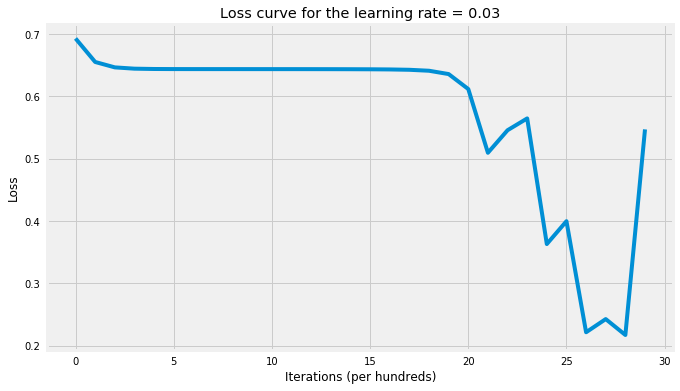

In [ ]:
# Setting layers dims
layers_dims = [X_train.shape[0], 5, 5, 1]

# NN with tanh activation fn
parameters_tanh = L_layer_model(
    X_train, y_train, layers_dims, learning_rate=0.03, num_iterations=3000,
    hidden_layers_activation_fn="tanh")

# Print the accuracy
accuracy(X_test, parameters_tanh, y_test, activation_fn="tanh")

The cost after 100 iterations is: 0.6556
The cost after 200 iterations is: 0.6468
The cost after 300 iterations is: 0.6447
The cost after 400 iterations is: 0.6441
The cost after 500 iterations is: 0.6440
The cost after 600 iterations is: 0.6440
The cost after 700 iterations is: 0.6440
The cost after 800 iterations is: 0.6440
The cost after 900 iterations is: 0.6440
The cost after 1000 iterations is: 0.6440
The cost after 1100 iterations is: 0.6439
The cost after 1200 iterations is: 0.6439
The cost after 1300 iterations is: 0.6439
The cost after 1400 iterations is: 0.6439
The cost after 1500 iterations is: 0.6439
The cost after 1600 iterations is: 0.6439
The cost after 1700 iterations is: 0.6438
The cost after 1800 iterations is: 0.6437
The cost after 1900 iterations is: 0.6435
The cost after 2000 iterations is: 0.6432
The cost after 2100 iterations is: 0.6423
The cost after 2200 iterations is: 0.6395
The cost after 2300 iterations is: 0.6259
The cost after 2400 iterations is: 0.5408
T

'The accuracy rate is: 42.00%.'

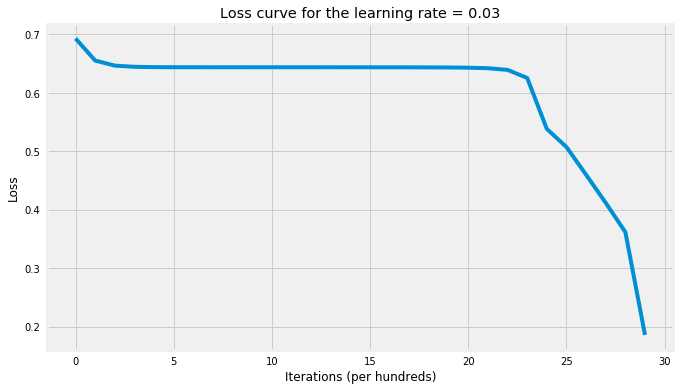

In [ ]:
# NN with relu activation fn
parameters_relu = L_layer_model(
    X_train, y_train, layers_dims, learning_rate=0.03, num_iterations=3000,
    hidden_layers_activation_fn="relu")

# Print the accuracy
accuracy(X_test, parameters_relu, y_test, activation_fn="relu")

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Conclusion
</h2>

The purpose of this notebook is to code Deep Neural Network step-by-step and explain the important concepts while doing that. We don't really care about the accuracy rate at this moment since there are tons of things we could've done to increase the accuracy which would be the subject of following notebooks. Below are some takeaways:
- Even if neural network can represent any function, it may fail to learn for two reasons:
    1. The optimization algorithm may fail to find the best value for the parameters of the desired (true) function.
        It can stuck in a local optimum.
    2. The learning algorithm may find different functional form that is different than the intended function due to overfitting.
- Even if neural network rarely converges and always stuck in a local minimum, it is still able to reduce the cost significantly and come up with very complex models with high test accuracy.
- The neural network we used in this notebook is standard fully connected network. However, there are two other kinds of networks:
    - Convolutional NN: Where not all nodes are connected. It's best in class for image recognition.
    - Recurrent NN: There is a feedback connections where output of the model is fed back into itself. It's used mainly in sequence modeling.
- The fully connected neural network also forgets what happened in previous steps and also doesn't know anything about the output.
- There are number of hyperparameters that we can tune using cross validation to get the best performance of our network:
    1. Learning rate ($\alpha$): Determines how big the step for each update of parameters.
        - Small $\alpha$ leads to slow convergence and may become computationally very expensive.
        - Large $\alpha$ may lead to overshooting where our learning algorithm may never converge.
    2. Number of hidden layers (depth): The more hidden layers the better, but comes at a cost computationally.
    3. Number of units per hidden layer (width): Research proven that huge number of hidden units per layer doesn't add to the improvement of the network.
    4. Activation function: Which function to use on hidden layers differs among applications and domains. It's a trial and error process to try different functions and see which one works best.
    5. Number of iterations.
- Standardize data would help activation units have similar range of values and avoid gradients to go out of control.